## SMOTE 过采样方法

- SMOTE-Regular 算法
- SMOTE-Borderline1 算法
- SMOTE-Borderline2 算法
- SMOTE-SVM 算法

In [1]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=1, n_redundant=1, flip_y=0,
                           n_features=2, n_clusters_per_class=1, n_samples=1000, random_state=10)
Counter(y)

Counter({1: 900, 0: 100})

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
Counter(y_res)

Counter({1: 900, 0: 900})

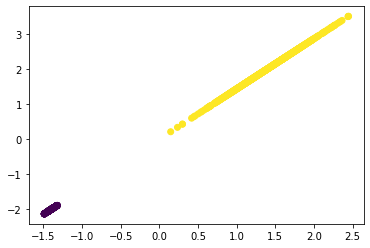

In [5]:
plt.scatter(X_res[:,0], X_res[:,1],c=y_res)
plt.show()

## 多种过采样方法的比较

In [6]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler

In [7]:
# 生成不平衡数据集
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)


# 图展示过采样结果
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

## 判别函数结果
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [8]:
X, y = create_dataset()
Counter(y)

Counter({2: 972, 1: 15, 0: 13})

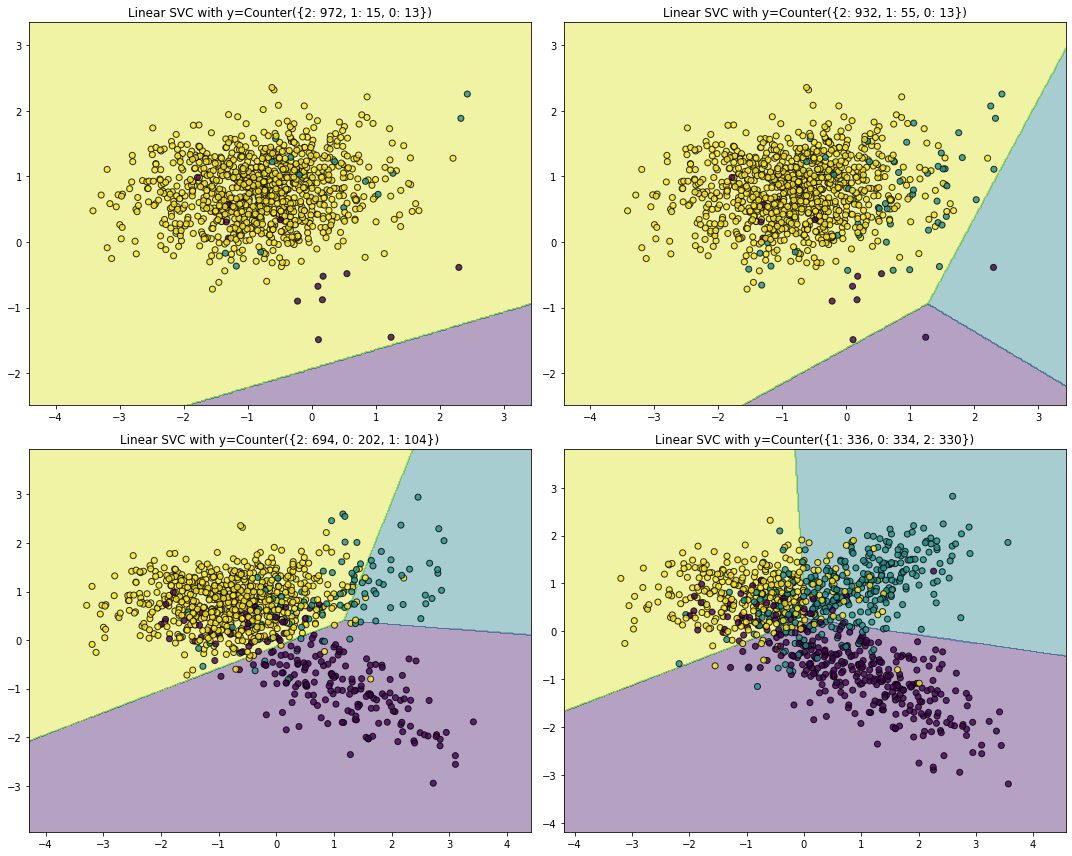

In [9]:
# 验证数据不同平衡率对模型的影响，如线性SVM
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = LinearSVC().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))
fig.tight_layout()

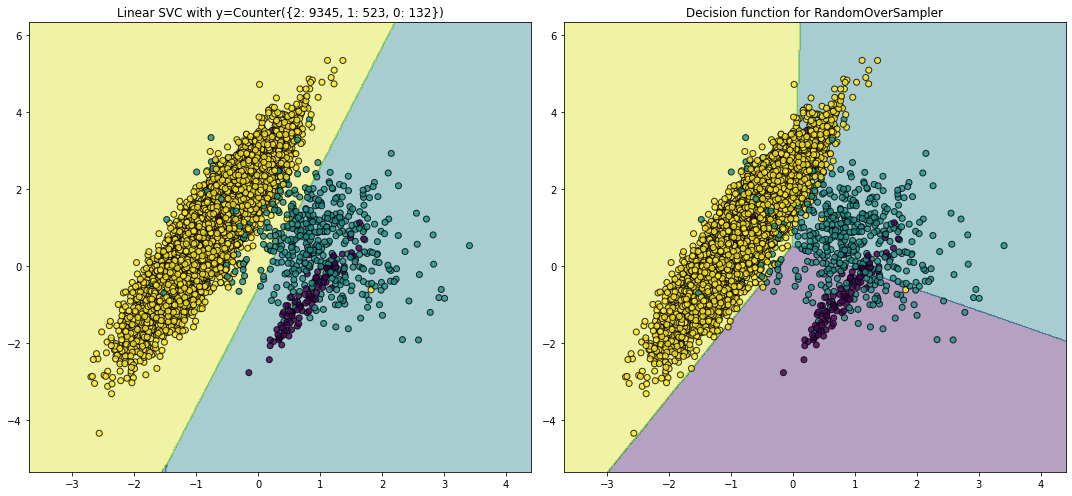

In [10]:
# 采用随机采样来平衡数据集：
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
pipe = make_pipeline(RandomOverSampler(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for RandomOverSampler')
fig.tight_layout()

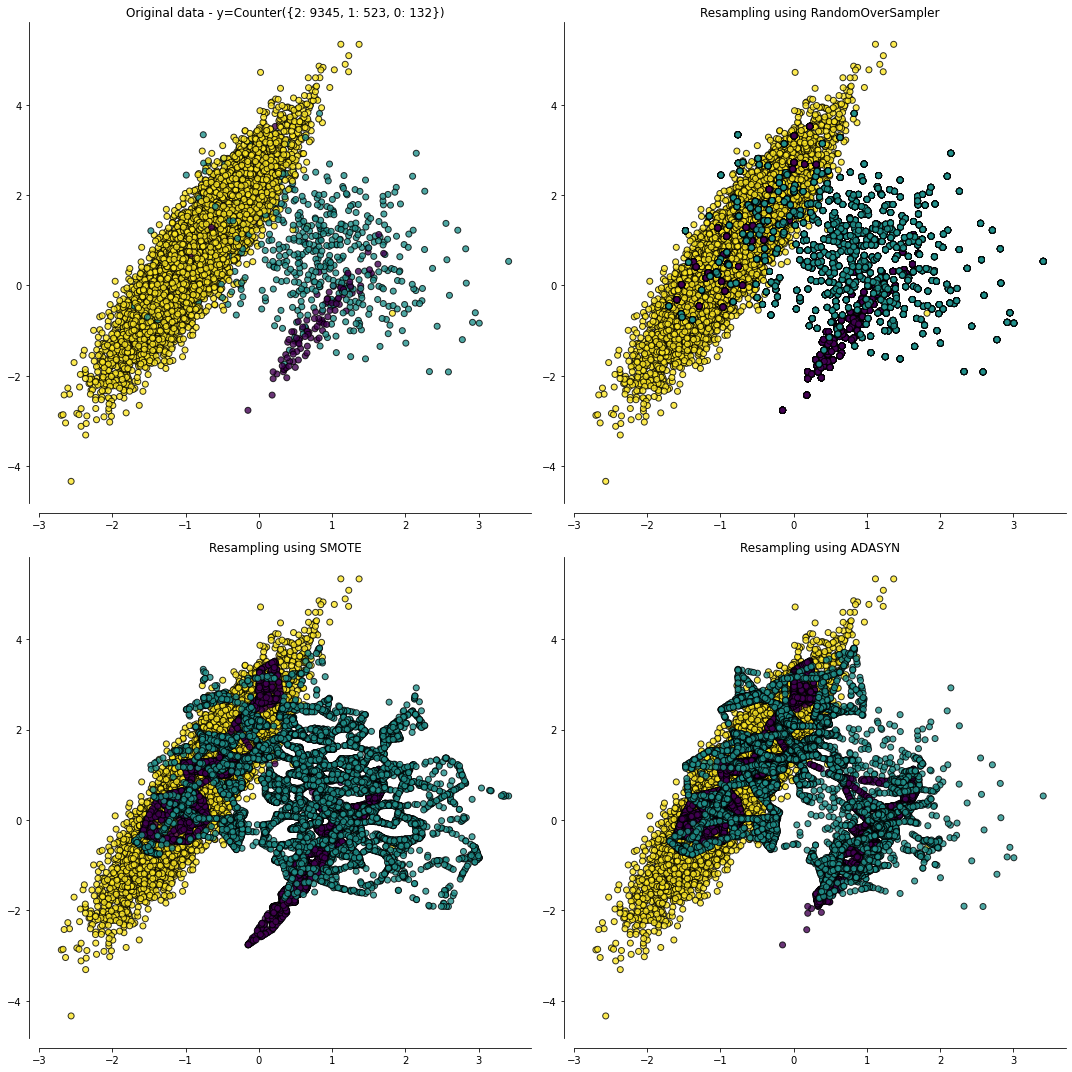

In [11]:
## 其它高级的过采样算法：ADASYN和SMOTE
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

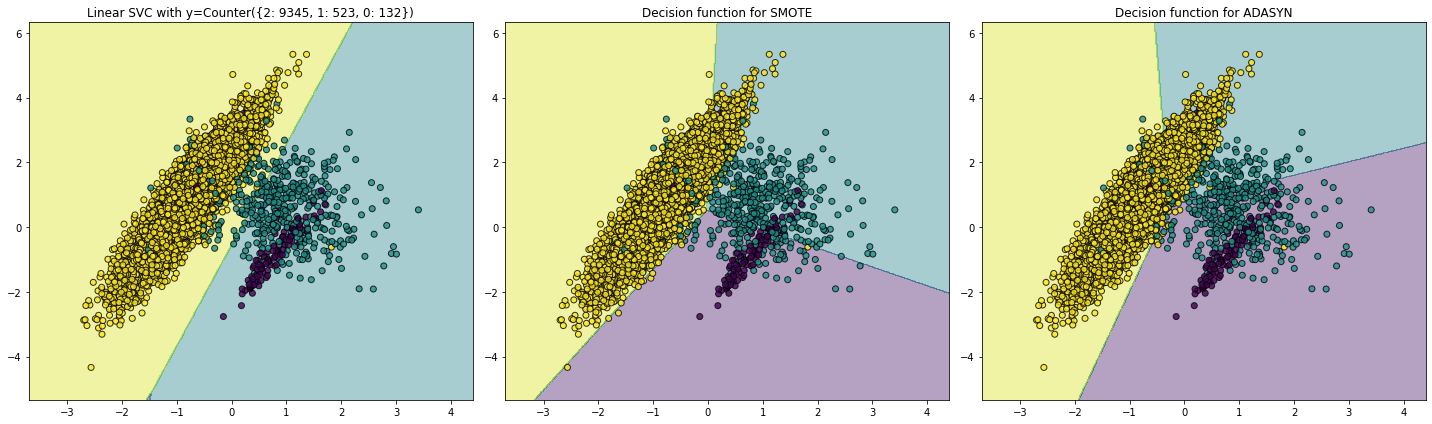

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))

clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
sampler = SMOTE()
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax2)
ax2.set_title('Decision function for {}'.format(sampler.__class__.__name__))
sampler = ADASYN()
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax3)
ax3.set_title('Decision function for {}'.format(sampler.__class__.__name__))
fig.tight_layout()

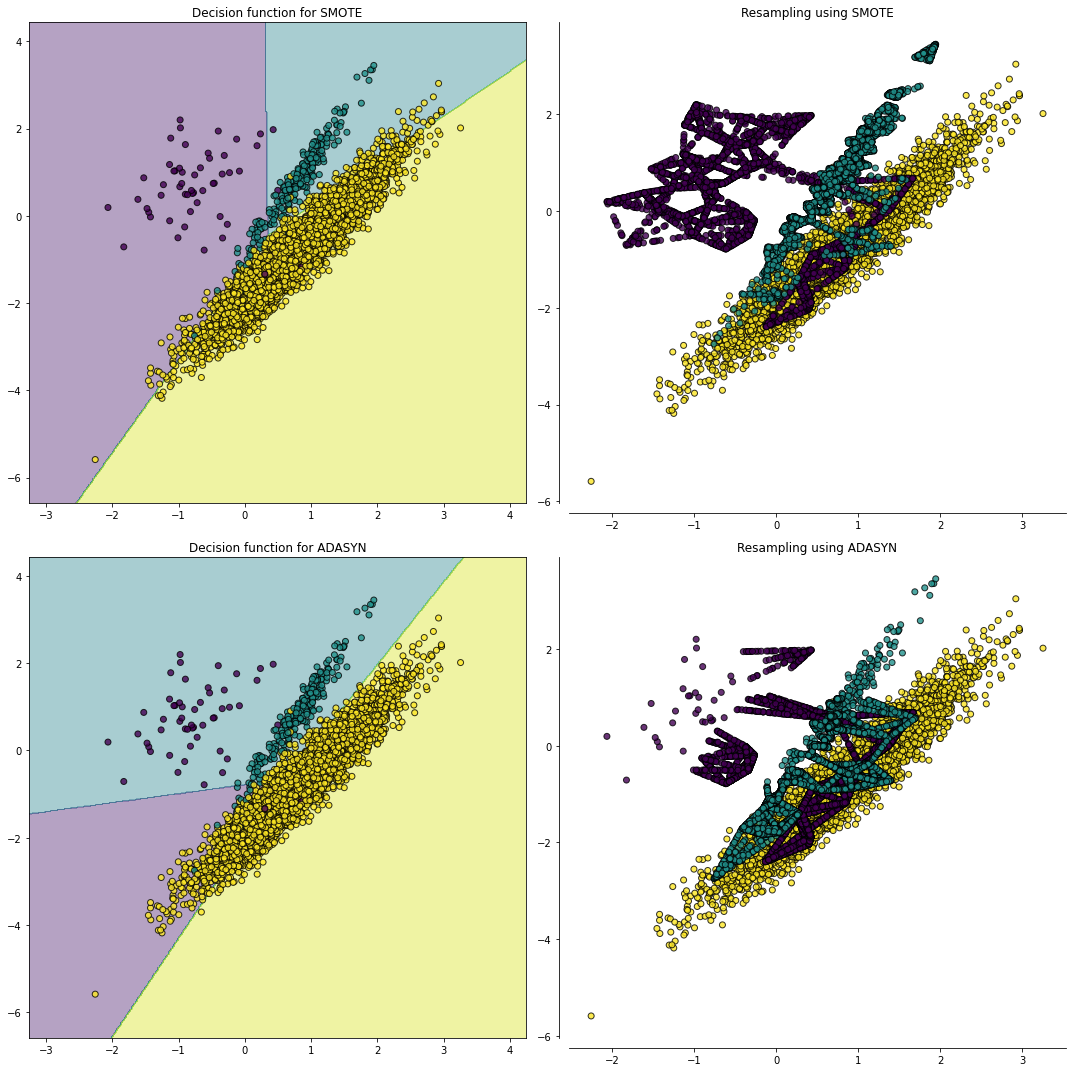

In [13]:
# 不同过采样方法对分类器的影响
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

ax_arr = ((ax1, ax2), (ax3, ax4))
for ax, sampler in zip(ax_arr, (SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

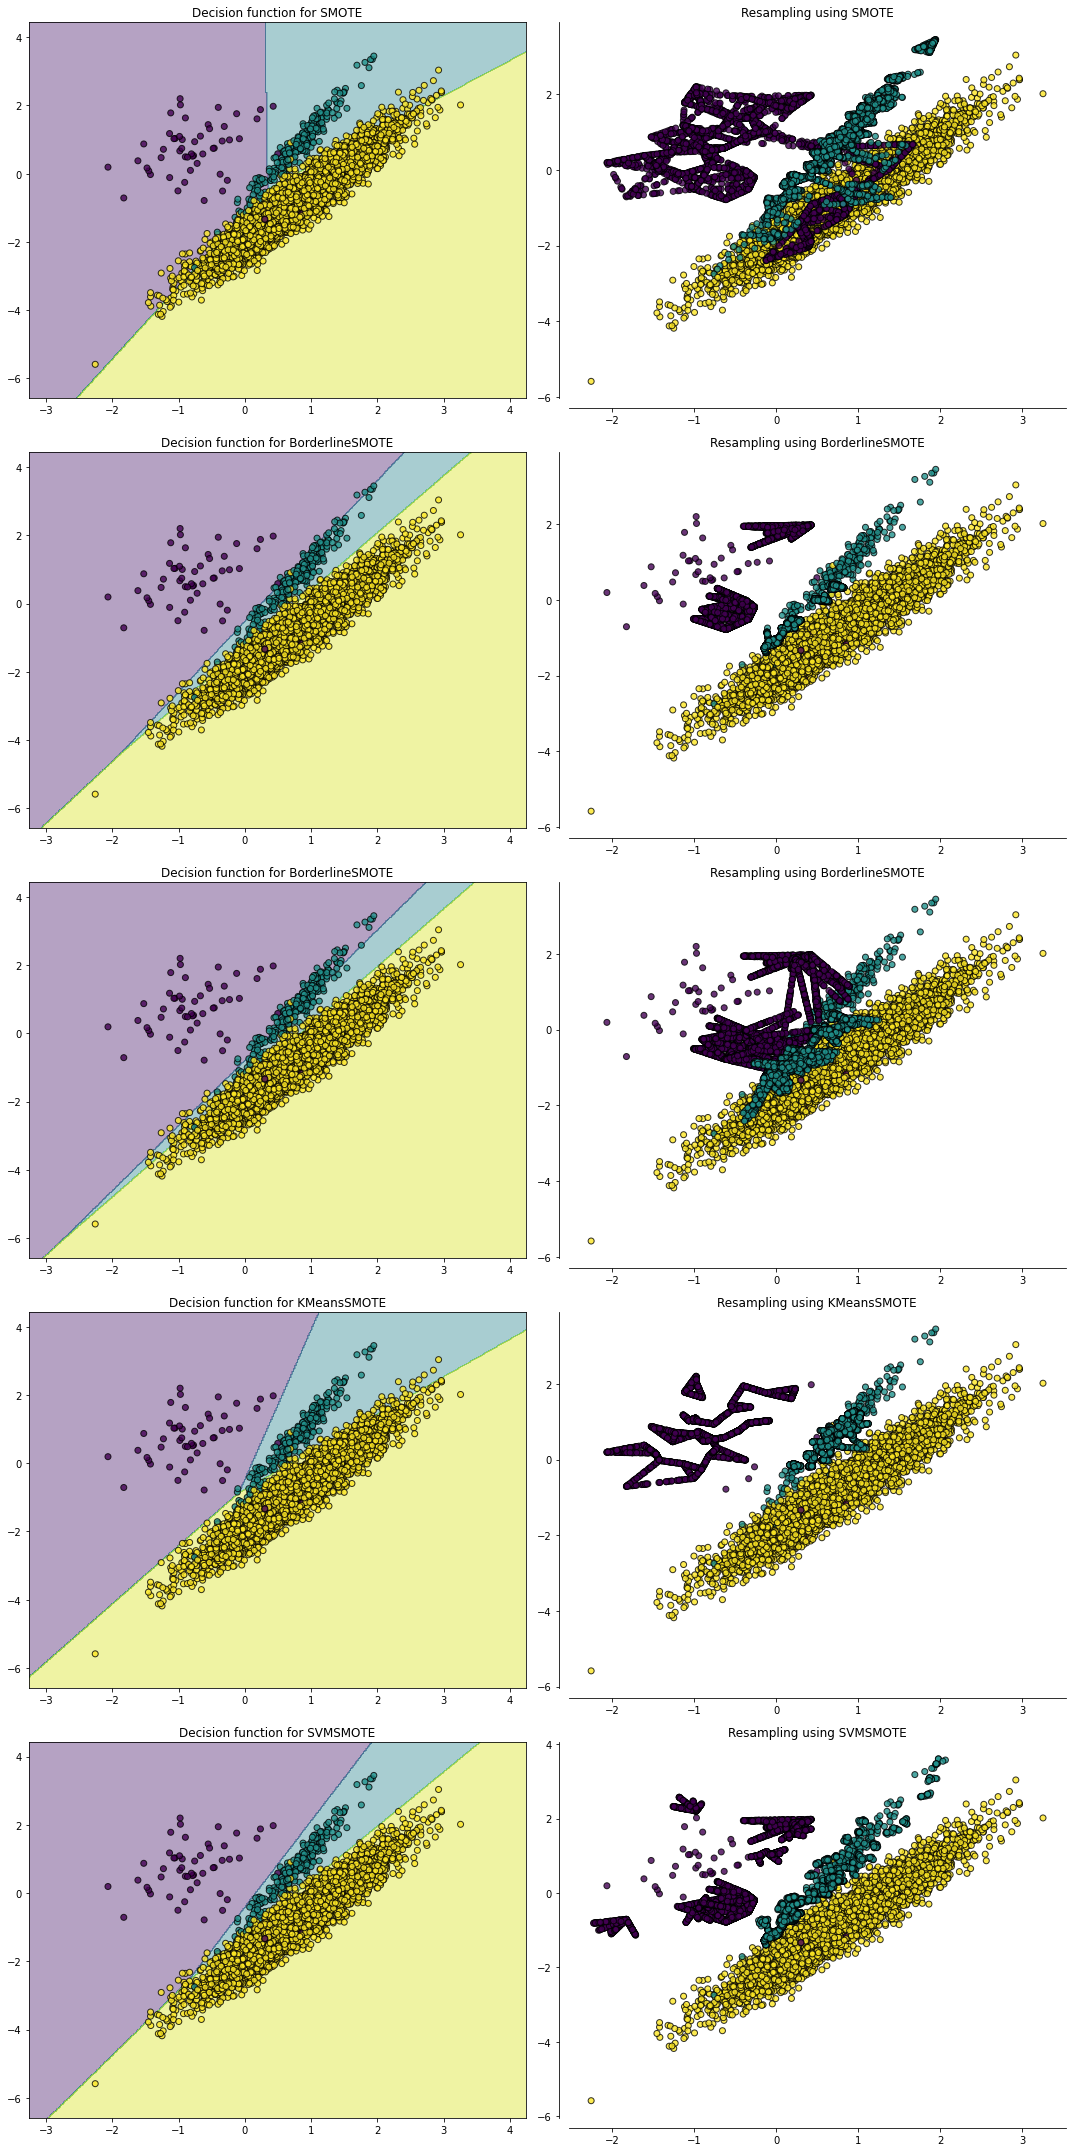

In [14]:
# 考虑不同SMOTE变种算法对分类器的影响
fig, ((ax1, ax2), (ax3, ax4),
      (ax5, ax6), (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 30))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)


ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10))
for ax, sampler in zip(ax_arr,
                       (SMOTE(random_state=0),
                        BorderlineSMOTE(random_state=0, kind='borderline-1'),
                        BorderlineSMOTE(random_state=0, kind='borderline-2'),
                        KMeansSMOTE(random_state=0),
                        SVMSMOTE(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

In [15]:
# 使用SMOTE-NC来处理连续变量与离散变量特征
rng = np.random.RandomState(42)
n_samples = 50
X = np.empty((n_samples, 3), dtype=object)
X[:, 0] = rng.choice(['A', 'B', 'C'], size=n_samples).astype(object)
X[:, 1] = rng.randn(n_samples)
X[:, 2] = rng.randint(3, size=n_samples)
y = np.array([0] * 20 + [1] * 30)

print('The original imbalanced dataset')
print(sorted(Counter(y).items()))
print('The first and last columns are containing categorical features:')
print(X[:5])

smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)
print('Dataset after resampling:')
print(sorted(Counter(y_resampled).items()))
print('SMOTE-NC will generate categories for the categorical features:')
print(X_resampled[-5:])

The original imbalanced dataset
[(0, 20), (1, 30)]
The first and last columns are containing categorical features:
[['C' -0.14021849735700803 2]
 ['A' -0.033193400066544886 2]
 ['C' -0.7490765234433554 1]
 ['C' -0.7783820070908942 2]
 ['A' 0.948842857719016 2]]
Dataset after resampling:
[(0, 30), (1, 30)]
SMOTE-NC will generate categories for the categorical features:
[['A' 0.5246469549655818 2]
 ['B' -0.3657680728116921 2]
 ['B' 0.9344237230779993 2]
 ['B' 0.3710891618824609 2]
 ['B' 0.3327240726719727 2]]
